# w8 SIFT and BLOBs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from IPython.display import display
from tqdm.notebook import tqdm 

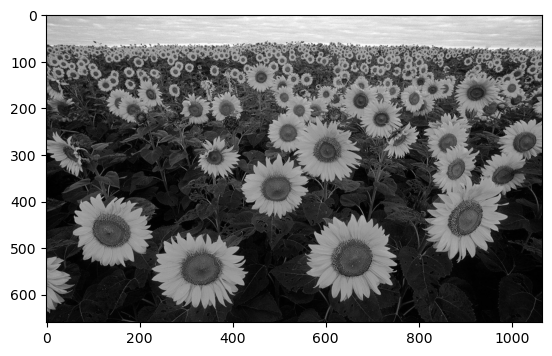

In [2]:
im = cv2.imread('data/sunflowers.jpg')[:,:,::-1]
im = im.astype(float).mean(2)/255
plt.imshow(im, cmap='gray')

In [3]:
def gaussian1DKernel(sigma:int) -> np.ndarray:
    """create a 1D gaussian kernel
    g: kernel
    gd: derivative of kernel"""
    if sigma == 0:
        raise ValueError("sigma must be non-zero")
    width = 5*sigma
    interval = np.arange(-width, width+1)
    g = 1/(np.sqrt(2*np.pi)*sigma) * np.exp(-interval**2/(2*sigma**2))
    gd = -interval/(np.sqrt(2*np.pi)*sigma**3) * np.exp(-interval**2/(2*sigma**2))
    g = g.reshape(-1,1)
    gd = gd.reshape(-1,1)
    return g, gd

In [4]:
# 8.1
def scaleSpaced2(im:np.ndarray, sigma:float, n:int) -> list:
    """Create a list of n blurred images of im, with sigma as the standard deviation of the Gaussian kernel.
    does the same as scaleSpaced, but uses cv2.GaussianBlur instead of cv2.filter2D"""
    return [cv2.GaussianBlur(im, (0,0), sigma * (2**i)) for i in range(n)]

def scaleSpaced(im:np.ndarray, sigma:float, n:int) -> list:
    """Create a list of n blurred images of im, with sigma as the standard deviation of the Gaussian kernel."""
    out = []
    for i in range(n):
        g, gd = gaussian1DKernel(sigma * (2**i))
        I = cv2.filter2D(cv2.filter2D(im, -1, kernel=g), -1, kernel=g.T)
        out.append(I)
    return out

sigma = 2; n = 7;
im_scales = scaleSpaced(im, sigma, n)

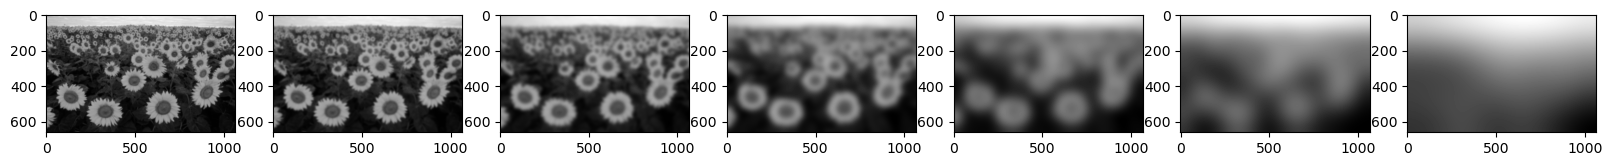

In [5]:
fig, ax = plt.subplots(1, n, figsize=(20, 10))
ax = ax.ravel()
for i, im_ in enumerate(im_scales):
    ax[i].imshow(im_, cmap='gray')

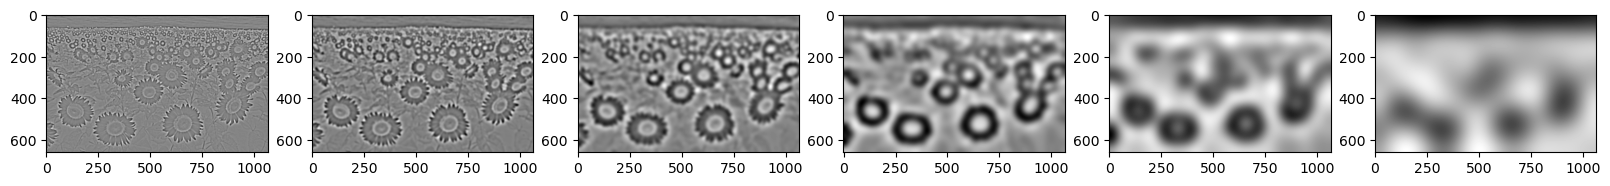

In [6]:
# 8.2
def differenceOfGaussians(im:np.ndarray, sigma:float, n:int) -> list:
    """r is a list of scale space DoGs of the original image im. 
    Like the scaleSpaced function, the returned images are all the same size as the original."""
    out = []
    im_scales = scaleSpaced(im, sigma, n)
    for i in range(n-1):
        out.append(im_scales[i+1] - im_scales[i])
    return out
DoG = differenceOfGaussians(im, sigma, n)

fig, ax = plt.subplots(1, n-1, figsize=(20, 10))
ax = ax.ravel()
for i, im_ in enumerate(DoG):
    ax[i].imshow(im_, cmap='gray')

In [7]:
# 8.3
def detectBlobs(im:np.ndarray, sigma:float, n:int, tau:float):
    """Detect blobs in the image im using the DoG method.
    sigma: standard deviation of the Gaussian kernel
    n: number of scales
    tau: threshold for blob detection"""
    DoGs = differenceOfGaussians(im, sigma, n)
    n = len(DoGs)
    MaxDoG = [cv2.dilate(abs(DoG), np.ones((3,3))) for DoG in DoGs]
    blobs = []

    for n_, DoG in tqdm(enumerate(DoGs)):
        r = DoG
        I = np.abs(r) > tau
        for i in range(1, r.shape[0]-1):
            for j in range(1, r.shape[1]-1):
                if I[i, j]:
                    if n_ == 0:
                        if r[i,j] > r[i+1,j] and r[i,j] > r[i-1,j] and r[i,j] > r[i,j+1] and r[i,j] > r[i,j-1] and r[i, j] > r[i+1,j+1] and r[i,j] > r[i-1,j-1] and r[i,j] > r[i+1,j-1] and r[i,j] > r[i-1,j+1] and r[i,j] > MaxDoG[n_+1][i,j]:
                            blobs.append((j, i, sigma*2**n_))
                    elif n_ == n-1:
                        if r[i,j] > r[i+1,j] and r[i,j] > r[i-1,j] and r[i,j] > r[i,j+1] and r[i,j] > r[i,j-1] and r[i, j] > r[i+1,j+1] and r[i,j] > r[i-1,j-1] and r[i,j] > r[i+1,j-1] and r[i,j] > r[i-1,j+1] and r[i,j] > MaxDoG[n_-1][i,j]:
                            blobs.append((j, i, sigma*2**n_))
                    else:
                        if r[i,j] > r[i+1,j] and r[i,j] > r[i-1,j] and r[i,j] > r[i,j+1] and r[i,j] > r[i,j-1] and r[i, j] > r[i+1,j+1] and r[i,j] > r[i-1,j-1] and r[i,j] > r[i+1,j-1] and r[i,j] > r[i-1,j+1] and r[i,j] > MaxDoG[n_+1][i,j] and r[i,j] > MaxDoG[n_-1][i,j]:
                            blobs.append((j, i, sigma*2**n_))
    return blobs

im = cv2.imread('data/sunflowers.jpg')[:,:,::-1]
im = im.astype(float).mean(2)/255
sigma = 2; n = 7; tau = 0.1
blobs = detectBlobs(im, sigma, n, tau)

0it [00:00, ?it/s]

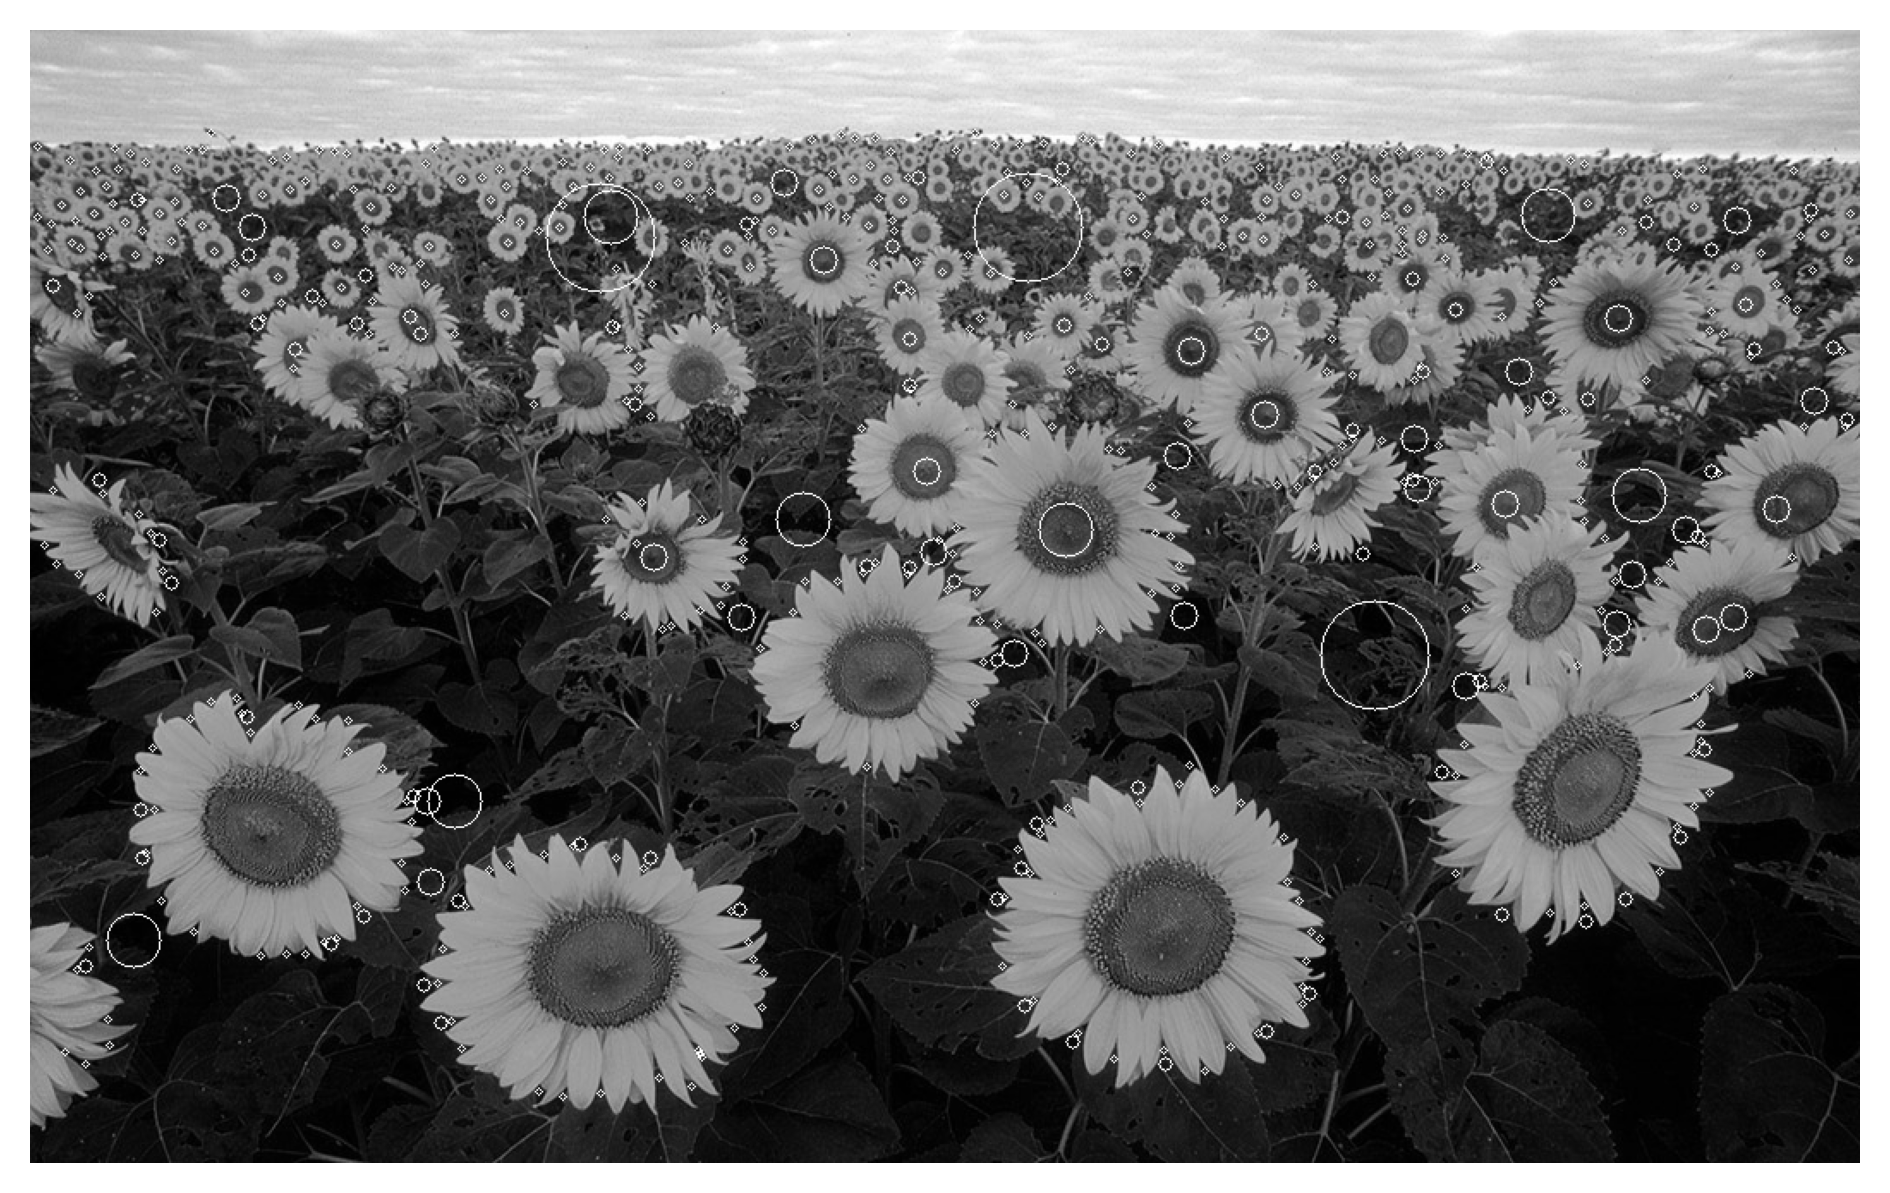

In [8]:
im = cv2.imread('data/sunflowers.jpg')[:,:,::-1]
im = im.astype(float).mean(2)/255
circles = [cv2.circle(im, (blob[0], blob[1]), blob[2], (1,0,0), 1) for blob in blobs]
fig, ax = plt.subplots(dpi=300,tight_layout=True)
ax.imshow(im, cmap='gray')
ax.axis('off');

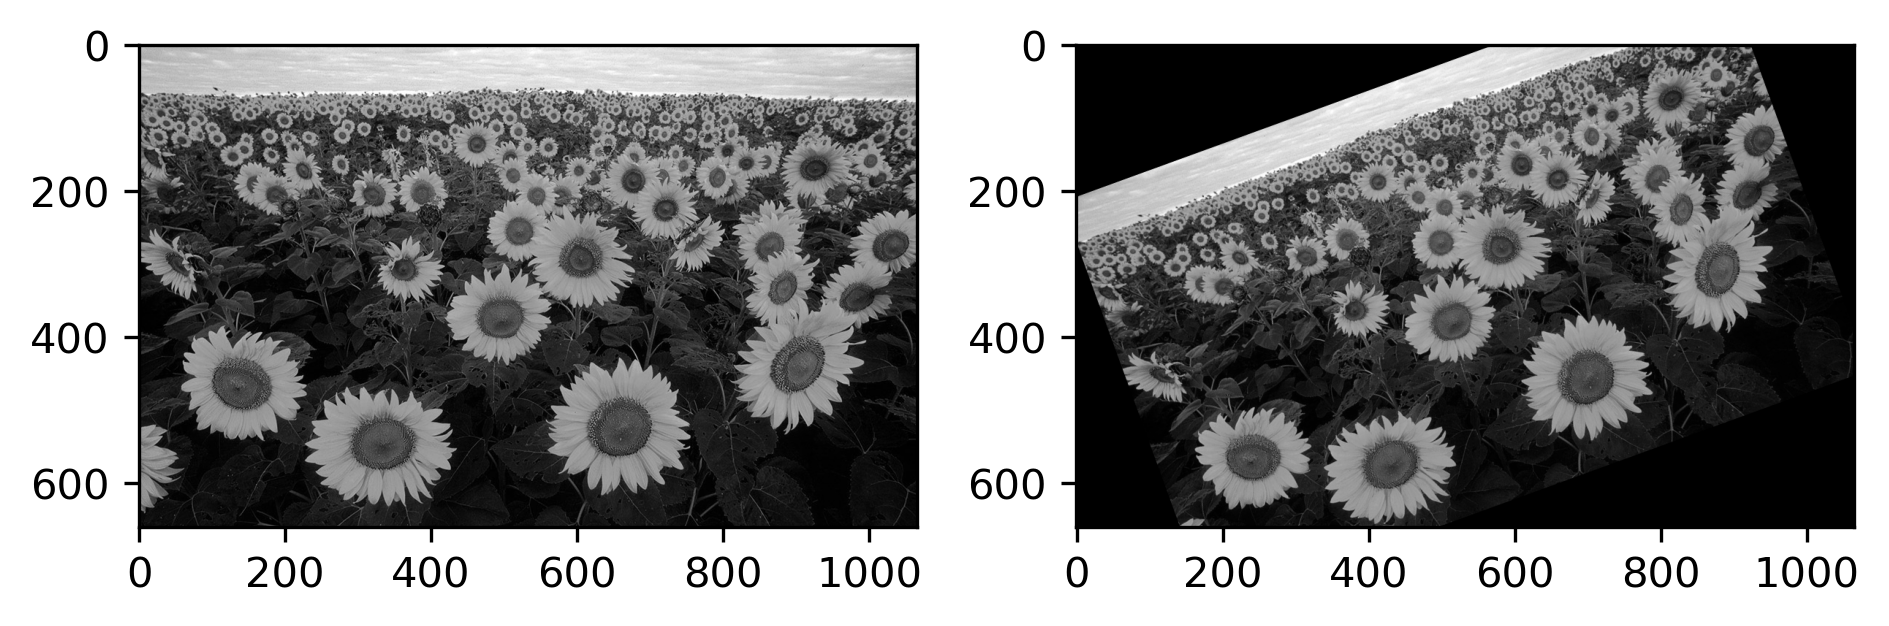

In [35]:
# 8.4
def transformIm(im:np.ndarray, theta:float, s:float) -> np.ndarray:
    """Transform the image im by rotation theta and scaling s"""
    r, c = im.shape
    M = cv2.getRotationMatrix2D((c/2, r/2), theta, s)
    return cv2.warpAffine(im, M, (c, r))
theta = 20; s = 0.9
imu = cv2.imread('data/sunflowers.jpg')[:,:,::-1]
imu = imu.mean(2).astype(np.uint8)
r_im = transformIm(imu, theta, s)
fig, ax = plt.subplots(1, 2 ,dpi=300,tight_layout=True)
ax[0].imshow(imu, cmap='gray')
ax[1].imshow(r_im, cmap='gray');

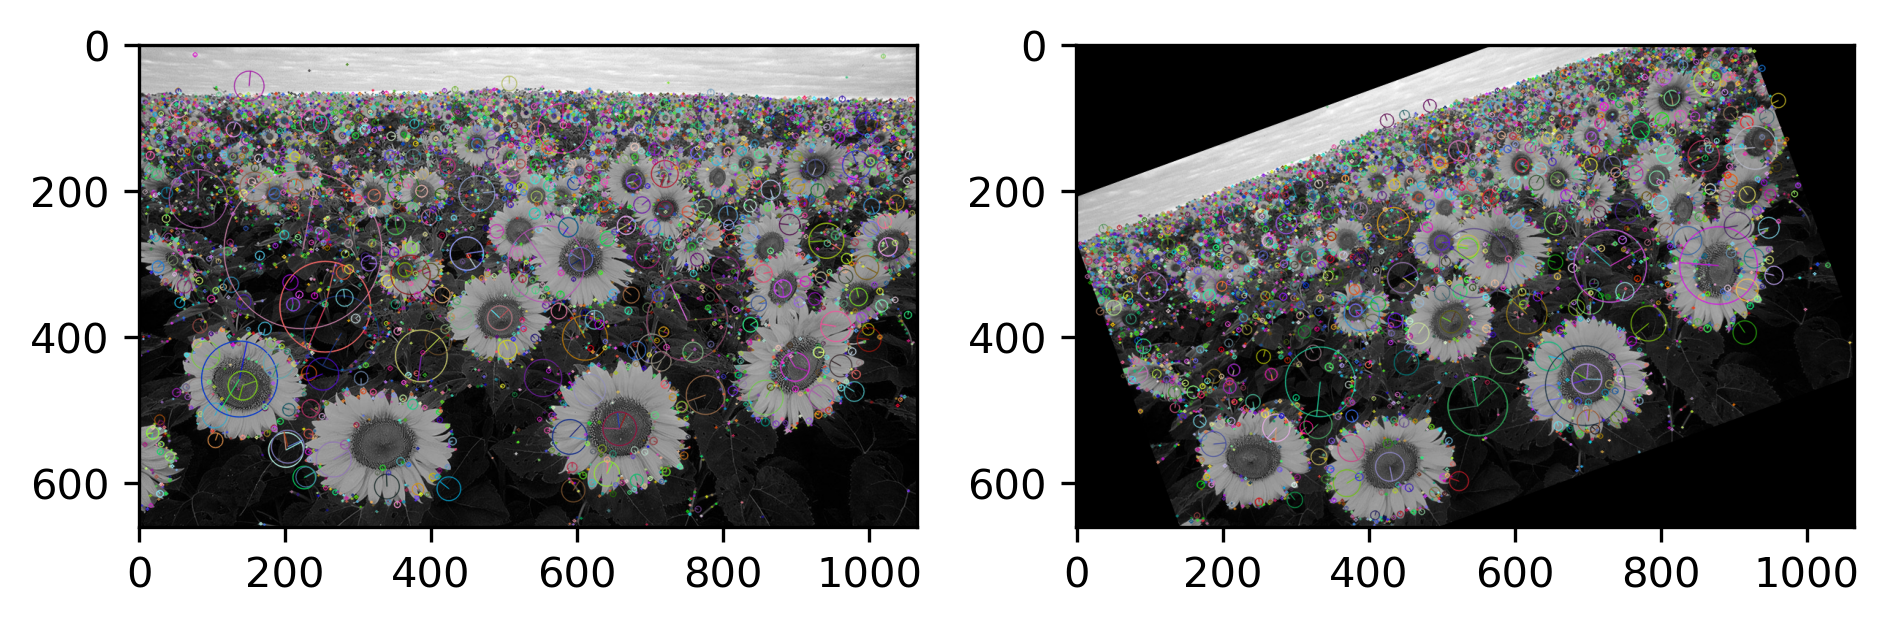

In [56]:
# 8.5 SIFT detector
# Applying SIFT detector
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(imu, None)
kp2, des2 = sift.detectAndCompute(r_im, None)
 
# Marking the keypoint on the image using circles
img1 = cv2.drawKeypoints(imu, kp1, imu, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img2 = cv2.drawKeypoints(r_im, kp2, r_im, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
fig, ax = plt.subplots(1,2, dpi=300,tight_layout=True)
ax[0].imshow(img1)
ax[1].imshow(img2)

The image shows the found keypoints

Next we will find the corresponding keypoints among both of the images

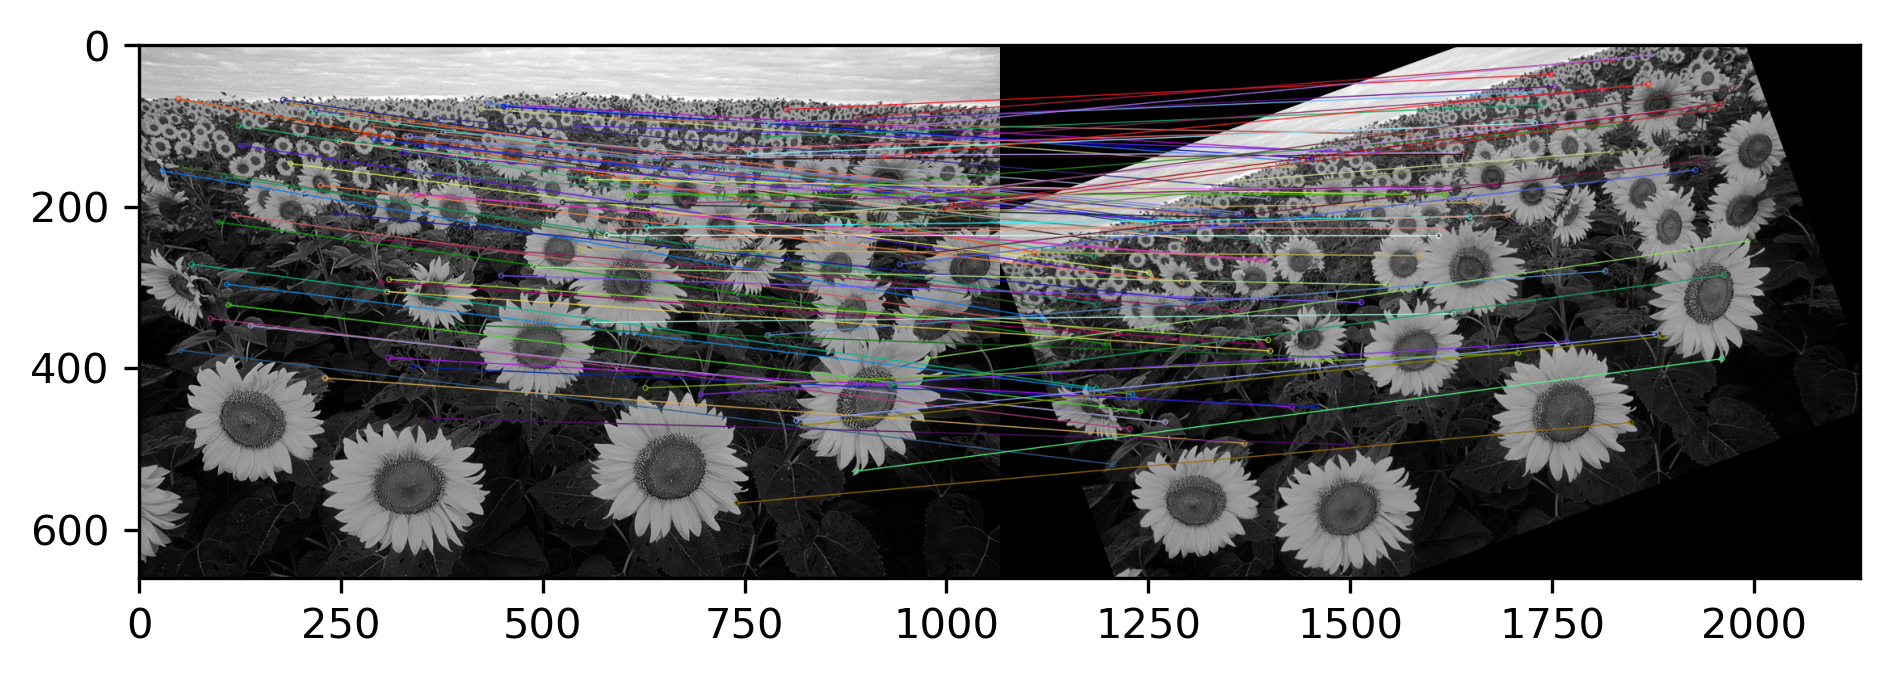

In [88]:
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)
good = []
for m, n in matches:
    # apply ratio test
    # can choose the ratio such that the match are considered good then the ratio is less than the selected ratio
    if m.distance < 0.15*n.distance:
        good.append([m])
img3 = cv2.drawMatchesKnn(imu, kp1, r_im, kp2, good[:1000], None, flags=2)
fig, ax = plt.subplots(dpi=300, tight_layout=True)
ax.imshow(img3);